# Obstacles Detection for visually impaired Using Fine-Tuning (Mobile-Net)

In [10]:
import torch, random
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [11]:
# Define the transforms
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Data loaders
train_dataset = datasets.ImageFolder(root='/kaggle/input/obstacles-dataset/obstacles dataset/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/obstacles-dataset/obstacles dataset/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers except the classifier
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Modify the classifier to match the number of classes
num_classes = len(train_dataset.classes)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

best_model = None
best_model_score = 0

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    mobilenet.train()
    train_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / len(train_loader.dataset)
    
    # Validation
    mobilenet.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)

    if best_model_score < val_accuracy :
        print(f'-> model changed : from {best_model_score} to {val_accuracy}')
        best_model_score = val_accuracy
        best_model = copy.deepcopy(mobilenet)
    
    print(f"Epoch {epoch+1}/{num_epochs}: ")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print('-'*40)

print(f'Best Accuracy : {val_accuracy:.4f}')

-> model changed : from 0 to 0.8263888888888888
Epoch 1/20: 
Train Loss: 1.2517, Train Accuracy: 0.6063
Val Loss: 0.7225, Val Accuracy: 0.8264
----------------------------------------
-> model changed : from 0.8263888888888888 to 0.8472222222222222
Epoch 2/20: 
Train Loss: 0.6924, Train Accuracy: 0.7902
Val Loss: 0.5538, Val Accuracy: 0.8472
----------------------------------------
Epoch 3/20: 
Train Loss: 0.5836, Train Accuracy: 0.8142
Val Loss: 0.5134, Val Accuracy: 0.8287
----------------------------------------
-> model changed : from 0.8472222222222222 to 0.875
Epoch 4/20: 
Train Loss: 0.5381, Train Accuracy: 0.8244
Val Loss: 0.4295, Val Accuracy: 0.8750
----------------------------------------
-> model changed : from 0.875 to 0.8773148148148148
Epoch 5/20: 
Train Loss: 0.4990, Train Accuracy: 0.8391
Val Loss: 0.4125, Val Accuracy: 0.8773
----------------------------------------
Epoch 6/20: 
Train Loss: 0.4951, Train Accuracy: 0.8410
Val Loss: 0.4316, Val Accuracy: 0.8727
--------

In [14]:
mobilenet = best_model

----------------------------------------
---- Final Result ----
Val Loss: 0.2867, Val Accuracy: 0.9190
Classification Report (Validation):
               precision    recall  f1-score   support

       chair       1.00      0.71      0.83        24
        door       0.87      0.92      0.90        51
       fence       0.67      0.83      0.74        12
 garbage_bin       0.93      0.82      0.87        17
    obstacle       0.97      0.97      0.97        91
       plant       0.96      1.00      0.98        24
     pothole       0.87      0.87      0.87        30
      stairs       0.90      0.93      0.92        60
       table       0.79      0.91      0.85        33
     vehicle       1.00      0.94      0.97        90

    accuracy                           0.92       432
   macro avg       0.90      0.89      0.89       432
weighted avg       0.92      0.92      0.92       432



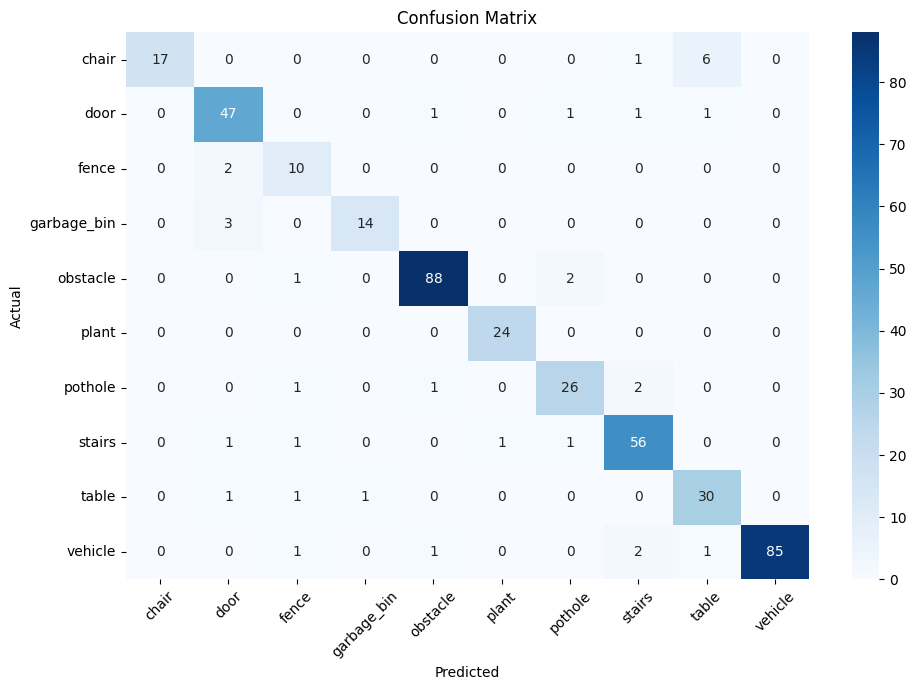

In [15]:
# Validation
mobilenet.eval()
val_loss, correct = 0.0, 0
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
            
        val_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

val_loss /= len(val_loader.dataset)
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
conf_matrix = confusion_matrix(all_labels, all_preds)

print('-'*40)
print(f'---- Final Result ----')
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")
print("Classification Report (Validation):\n", report)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [16]:
def visualize_predictions(model, dataset, num_classes=5, device='cpu'):

    # Map class indices to names
    class_to_idx = dataset.class_to_idx  # Class to index mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    
    # Randomly sample one image per class
    sampled_images = {}
    for class_label in random.sample(list(class_to_idx.values()), num_classes):
        for i in range(len(dataset)):
            img, label = dataset[i]
            if label == class_label:
                sampled_images[class_label] = (img, label)
                break  # Stop after finding one example for the class
    
    # Prepare for predictions
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
        for ax, (class_label, (img, label)) in zip(axes, sampled_images.items()):
            # Prepare image for model
            input_img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
            output = model(input_img)
            pred_label = output.argmax(dim=1).item()  # Get the predicted class index
            
            # Prepare the image for visualization
            img = img.numpy().transpose((1, 2, 0))  # Convert tensor to HxWxC format
            img = np.clip(
                img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]),
                0, 1
            )
            
            # Display the image
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(
                f"True: {idx_to_class[label]}\nPred: {idx_to_class[pred_label]}",
                fontsize=10,
                color="green" if label == pred_label else "red"
            )
    
    plt.tight_layout()
    plt.show()

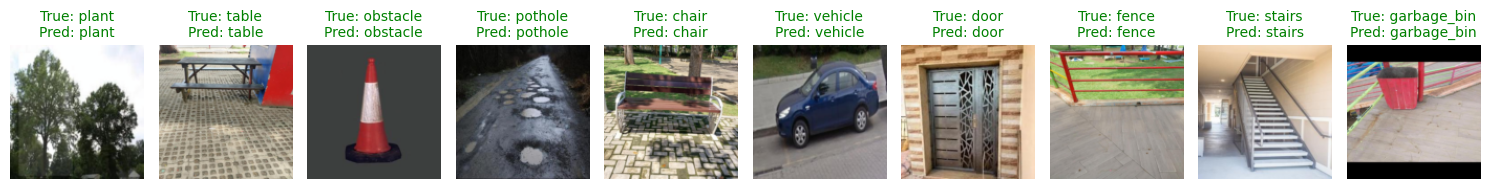

In [17]:
visualize_predictions(mobilenet, val_dataset, num_classes=10, device='cuda')

In [18]:
torch.save(mobilenet.state_dict(), '/kaggle/working/obstacle_detection_mobilenet.pth')